# Start

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 8.1 MB/s 
     |████████████████████████████████| 182 kB 8.7 MB/s 
     |████████████████████████████████| 7.6 MB 52.1 MB/s 


In [ ]:
import torch
import matplotlib.pyplot as plt
import nltk
import csv
import pandas as pd
import re
import pickle
import os
from transformers import DistilBertTokenizerFast, DistilBertModel

In [ ]:
os.chdir('/content/drive/MyDrive/')
!pwd

/content/drive/MyDrive


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('bert-base-uncased')
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/lcp_single_train.tsv", sep='\t')

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/lcp_single_test_wlabel.tsv", sep='\t')

In [ ]:
test.head()

id corpus  \
0  3K8CQCU3KE19US5SN890DFPK3SANWR  bible   
1  3Q2T3FD0ON86LCI41NJYV3PN0BW3MV  bible   
2  3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B  bible   
3  3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD  bible   
4  3QREJ3J433XSBS8QMHAICCR0BQ1LKR  bible   

                                            sentence     token  complexity  \
0  But he, beckoning to them with his hand to be ...      hand    0.000000   
1  If I forget you, Jerusalem, let my right hand ...      hand    0.197368   
2  the ten sons of Haman the son of Hammedatha, t...      hand    0.200000   
3  Let your hand be lifted up above your adversar...      hand    0.267857   
4  Abimelech chased him, and he fled before him, ...  entrance    0.000000   

                                      sent_processed  
0  [But, he, beckoning, to, them, with, his, hand...  
1  [If, I, forget, you, Jerusalem, let, my, right...  
2  [the, ten, sons, of, Haman, the, son, of, Hamm...  
3  [Let, your, hand, be, lifted, up, above, your,...  
4  [Abimelech, chased, him, and, he, fled, before...

In [ ]:
def preprocess(df):
  t = df.token
  s = df.sentence

  proc = []
  for token, sentence in zip(t, s):
    output = []
    sentence = re.sub(r"[^a-zA-Z\s]+", "", sentence)
    token = str(token).lower()
    sentence = str(sentence).lower()
    #output = "[CLS] " + token + " [SEP] " + sentence + " [SEP]"
    #output.append([token, sentence])
    proc.append([token, sentence])

  df['processed'] = proc

In [ ]:
preprocess(data)
preprocess(test)

In [ ]:
MAX_LEN = 512

In [ ]:
s = []
for i in range(len(test.sentence)):
  s.append(re.sub(r"[^a-zA-Z\s]+", "", test.sentence[i]).split())
test['sent_processed'] = s

s = []
for i in range(len(data.sentence)):
  s.append(re.sub(r"[^a-zA-Z\s]+", "", data.sentence[i]).split())
data['sent_processed'] = s

In [ ]:
train_data = data[['sentence','sent_processed']]
train_label = pd.DataFrame(data.complexity)
train_token = pd.DataFrame(data.token)

In [ ]:
test_data = test[['sentence','sent_processed']]
test_label = pd.DataFrame(test.complexity)
test_token = pd.DataFrame(test.token)

In [ ]:
len(test_data)

917

In [ ]:
test.head()

id corpus  \
0  3K8CQCU3KE19US5SN890DFPK3SANWR  bible   
1  3Q2T3FD0ON86LCI41NJYV3PN0BW3MV  bible   
2  3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B  bible   
3  3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD  bible   
4  3QREJ3J433XSBS8QMHAICCR0BQ1LKR  bible   

                                            sentence     token  complexity  \
0  But he, beckoning to them with his hand to be ...      hand    0.000000   
1  If I forget you, Jerusalem, let my right hand ...      hand    0.197368   
2  the ten sons of Haman the son of Hammedatha, t...      hand    0.200000   
3  Let your hand be lifted up above your adversar...      hand    0.267857   
4  Abimelech chased him, and he fled before him, ...  entrance    0.000000   

                                           processed  
0  [hand, but he beckoning to them with his hand ...  
1  [hand, if i forget you jerusalem let my right ...  
2  [hand, the ten sons of haman the son of hammed...  
3  [hand, let your hand be lifted up above your a...  
4  [entrance, abimelech chased him and he fled be...

In [ ]:
len(test_token)

917

In [ ]:
data.head()

id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  \
0  Behold, there came up out of the river seven c...     river    0.000000   
1  I am a fellow bondservant with you and with yo...  brothers    0.000000   
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000   
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000   
4                He has put my brothers far from me.  brothers    0.263889   

                                           processed  
0  [river, behold there came up out of the river ...  
1  [brothers, i am a fellow bondservant with you ...  
2  [brothers, the man the lord of the land said t...  
3  [brothers, shimei had sixteen sons and six dau...  
4     [brothers, he has put my brothers far from me]

In [ ]:
train_label.head()

complexity
0    0.000000
1    0.000000
2    0.050000
3    0.150000
4    0.263889

In [ ]:
train_token.head()

token
0     river
1  brothers
2  brothers
3  brothers
4  brothers

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def get_embeddings(train_data, train_token, train_label):
  token_ = []
  sentence_ = []
  label_ = []
  for i, (sent, sent_processed, token) in \
    enumerate(zip(train_data.sentence, train_data.sent_processed, train_token.token)):

    # Get the index of token in the sentence
    if token in sent_processed:
      word_id = sent_processed.index(token)
      label_.append(train_label.complexity[i])
    else:
      continue

    # Tokenize sentence and convert to token_id
    encoded = tokenizer.encode_plus(sent, return_tensors="pt",
                                    padding="max_length", max_length=MAX_LEN,
                                    truncation=True)

    # Parse to model to embed
    with torch.no_grad():
      output = model(**encoded)

    # Take the last 4 layers only, sum and take the mean
    # Dimension = (layers, batch_size, len_token, 768)
    # Each token is represented with a vector of length 768 (# features)
    # Sum and squeeze, dimension is now [len_token x 768]
    sentence_vec = torch.stack(output.hidden_states[-4:]).sum(0).squeeze(0)

    # Extract the embeddings for token
    token_vec = sentence_vec[word_id]

    sentence_vec = sentence_vec.mean(axis=1) # 1D tensor with size len_token
    token_vec = token_vec.mean() # Scalar
    token_.append(token_vec)
    sentence_.append(sentence_vec)

    # Pickle dump every 1000 sentence
    if i % 200 == 0:
      with open('/content/drive/MyDrive/lcp_sentvec_test.pkl', 'wb') as file:
        # save embedded sentence vector
        pickle.dump(sentence_, file)
        file.close()

      with open('/content/drive/MyDrive/lcp_tokvec_test.pkl', 'wb') as file:
        # save embedded token vector
        pickle.dump(token_, file)
        file.close()

      with open('/content/drive/MyDrive/lcp_labelvec_test.pkl', 'wb') as file:
        # save embedded sentence vector
        pickle.dump(label_, file)
        file.close()
      print(f"Done {i+1} sentences")

  return sentence_, token_, label_

In [ ]:
def get_embeddings(df):
  token_ = []
  sentence_ = []
  label_ = []
  for i, sent_processed in enumerate(df.sentence):

    # Get the index of token in the sentence
    # if token in sent_processed:
    #   word_id = sent_processed.index(token)
    #   label_.append(train_label.complexity[i])
    # else:
    #   continue

    # Tokenize sentence and convert to token_id
    encoded = tokenizer.encode_plus(sent_processed, return_tensors="pt",
                                    padding="max_length", max_length=MAX_LEN,
                                    truncation=True)

    # Parse to model to embed
    with torch.no_grad():
      output = model(**encoded)

    # Take the last 4 layers only, sum and take the mean
    # Dimension = (layers, batch_size, len_token, 768)
    # Each token is represented with a vector of length 768 (# features)
    # Sum and squeeze, dimension is now [len_token x 768]
    sentence_vec = torch.stack(output.hidden_states[-4:]).sum(0).squeeze(0)

    # Extract the embeddings for token
    #token_vec = sentence_vec[word_id]

    sentence_vec = sentence_vec.mean(axis=1) # 1D tensor with size len_token
    #token_vec = token_vec.mean() # Scalar
    #token_.append(token_vec)
    sentence_.append(sentence_vec)

    # Pickle dump every 1000 sentence
    if i % 200 == 0:
      with open('/content/drive/MyDrive/justtoletitrun.pkl', 'wb') as file:
        # save embedded sentence vector
        pickle.dump(sentence_, file)
        file.close()

      # with open('/content/drive/MyDrive/lcp_labelvec_train2.pkl', 'wb') as file:
      #   # save embedded sentence vector
      #   pickle.dump(label_, file)
      #   file.close()
      # print(f"Done {i+1} sentences")

  return sentence_

In [ ]:
ran = get_embeddings(data)

In [ ]:
train_sent_vec3 = get_embeddings(data)

In [ ]:
test_data = get_embeddings(test)


In [ ]:
test.head()

id corpus  \
0  3K8CQCU3KE19US5SN890DFPK3SANWR  bible   
1  3Q2T3FD0ON86LCI41NJYV3PN0BW3MV  bible   
2  3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B  bible   
3  3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD  bible   
4  3QREJ3J433XSBS8QMHAICCR0BQ1LKR  bible   

                                            sentence     token  complexity  \
0  But he, beckoning to them with his hand to be ...      hand    0.000000   
1  If I forget you, Jerusalem, let my right hand ...      hand    0.197368   
2  the ten sons of Haman the son of Hammedatha, t...      hand    0.200000   
3  Let your hand be lifted up above your adversar...      hand    0.267857   
4  Abimelech chased him, and he fled before him, ...  entrance    0.000000   

                                           processed  
0  [hand, but he beckoning to them with his hand ...  
1  [hand, if i forget you jerusalem let my right ...  
2  [hand, the ten sons of haman the son of hammed...  
3  [hand, let your hand be lifted up above your a...  
4  [entrance, abimelech chased him and he fled be...

In [ ]:
with open('/content/drive/MyDrive/lcp_sentvec_train4.pkl', 'wb') as file:
        # save embedded sentence vector
        pickle.dump(train_sent_vec3, file)
        file.close()

In [ ]:
with open('/content/drive/MyDrive/lcp_sentvec_test4.pkl', 'wb') as file:
        # save embedded sentence vector
        pickle.dump(test_data, file)
        file.close()

In [ ]:
test_labels = test.complexity
len(test_labels)

917

In [ ]:
test_sent_vec, test_token_vec, test_label_vec = get_embeddings(test_data, test_token, test_label)

In [ ]:
with open('/content/drive/MyDrive/lcp_sentvec_test.pkl', 'wb') as file:
        # save embedded sentence vector
    pickle.dump(test_sent_vec, file)
    file.close()

with open('/content/drive/MyDrive/lcp_tokvec_test.pkl', 'wb') as file:
        # save embedded token vector
    pickle.dump(test_token_vec, file)
    file.close()

with open('/content/drive/MyDrive/lcp_labelvec_test.pkl', 'wb') as file:
    # save embedded sentence vector
    pickle.dump(test_label_vec, file)
    file.close()

In [ ]:
len(sent_processed)

214

In [ ]:
token

'VI'

In [ ]:
len(sentence_vec)

128

## Pickle dump sentence and token vectors

In [ ]:
with open('/content/drive/MyDrive/lcp_sentvec.pkl', 'wb') as file:
    # save embedded sentence vector
    pickle.dump(sentence_vector, file)
    file.close()

with open('/content/drive/MyDrive/lcp_tokvec.pkl', 'wb') as file:
    # save embedded token vector
    pickle.dump(token_vector, file)
    file.close()

with open('/content/drive/MyDrive/lcp_labelvec.pkl', 'wb') as file:
    # save embedded sentence vector
    pickle.dump(label_vector, file)
    file.close()

In [ ]:
sentence_vect2 = sentence_vector.copy()
token_vect2 = token_vector.copy()
label_vect2 = label_vector.copy()

In [ ]:
len(label_vector)

7615

##Pickle load

In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec_train2.pkl",'rb')
sentence_vector = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec_train3.pkl",'rb')
sentence_vector2 = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec_train4.pkl",'rb')
train_sent_vec3 = pickle.load(file)
file.close()

In [ ]:
len(sentence_vector2) + len(sentence_vector)

7602

In [ ]:
encoded = tokenizer.encode_plus(data.processed[0], return_tensors="pt",
                                    padding="max_length", max_length=MAX_LEN,
                                    truncation=True)
with torch.no_grad():
    output = model(**encoded)

    # Take the last 4 layers only, sum and take the mean
    # Dimension = (layers, batch_size, len_token, 768)
    # Each token is represented with a vector of length 768 (# features)
    # Sum and squeeze, dimension is now [len_token x 768]
    sentence_vec = torch.stack(output.hidden_states[-4:]).sum(0).squeeze(0)

    # Extract the embeddings for token
    #token_vec = sentence_vec[word_id]

    sentence_vec = sentence_vec.mean(axis=1)

In [ ]:
sentence_vec

In [ ]:
label1 = data.complexity[:4401]

In [ ]:
label2 = data.complexity[4402:7603]

In [ ]:
label3 = data.complexity[7602:]

In [ ]:
import numpy as np

In [ ]:
train_data = torch.stack(sentence_vector + sentence_vector2 + train_sent_vec3).cpu().detach().numpy()

In [ ]:
train_label = np.asarray(label1.tolist() + label2.tolist() + label3.tolist())

In [ ]:
assert(len(train_data) == len(train_label))

In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec_test4.pkl",'rb')
test_data = pickle.load(file)
file.close()

test_data_np = torch.stack(test_data).cpu().detach().numpy()

In [ ]:
test_data_np

array([[-0.10550835, -0.09882232, -0.1008235 , ..., -0.12223697,
        -0.11202714, -0.11500826],
       [-0.10373787, -0.09189739, -0.0969409 , ..., -0.11203813,
        -0.10751086, -0.10863078],
       [-0.10576713, -0.09942407, -0.10661007, ..., -0.1185413 ,
        -0.11403075, -0.11685009],
       ...,
       [-0.10918488, -0.09952457, -0.10876077, ..., -0.12804402,
        -0.11653217, -0.12066736],
       [-0.10372736, -0.09229359, -0.10520828, ..., -0.11715301,
        -0.11155543, -0.11197468],
       [-0.10424139, -0.10348066, -0.099792  , ..., -0.10873768,
        -0.10662822, -0.10854622]], dtype=float32)

In [ ]:
test_labels = np.asarray(test.complexity.tolist())

In [ ]:
assert(len(test_labels) == len(test_data_np))

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report
from scipy.stats import pearsonr

In [ ]:
def get_metric(y_true, y_pred):
  print("R2_score is: ", r2_score(y_true, y_pred))
  print("MAE is: ", mean_absolute_error(y_true, y_pred))
  print("MSE is: ", mean_squared_error(y_true, y_pred))
  print("Pearson's R is: ", pearsonr(y_true, y_pred)[0])
  print("\n")
  y_true_cat = np.floor(y_true*5)
  y_pred_cat = np.floor(y_pred*5)
  print(classification_report(y_true_cat, y_pred_cat))

In [ ]:
from sklearn import svm

In [ ]:
regr = svm.SVR()

In [ ]:
regr.fit(train_data, train_label)

SVR()

In [ ]:
pred_svm = regr.predict(test_data_np)

In [ ]:
np.floor(pred_svm * 5)

In [ ]:
get_metric(pred_svm, test_labels)

R2_score is:  -4.962241447863941
MAE is:  0.10655910581816666
MSE is:  0.017939544518218296
Pearson's R is:  0.11014681956122432


              precision    recall  f1-score   support

         0.0       0.01      0.17      0.02        12
         1.0       0.94      0.62      0.74       855
         2.0       0.09      0.26      0.13        50
         3.0       0.00      0.00      0.00         0

    accuracy                           0.59       917
   macro avg       0.26      0.26      0.22       917
weighted avg       0.88      0.59      0.70       917



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import tree

In [ ]:
lcp_tree = tree.DecisionTreeRegressor()

In [ ]:
lcp_tree.fit(train_data, train_label)

DecisionTreeRegressor()

In [ ]:
pred_lcp = lcp_tree.predict(test_data_np)

In [ ]:
np.floor(pred_lcp * 5)

array([2., 0., 1., 1., 2., 0., 0., 1., 1., 2., 0., 1., 1., 0., 1., 2., 1.,
       2., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 2., 0., 1., 0., 1., 2., 2., 0., 1., 2., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 2., 1., 1., 0., 2., 1., 1., 2., 0., 2.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 2., 2., 0., 2., 1., 1.,
       1., 1., 3., 1., 1., 1., 2., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       2., 0., 1., 0., 1., 2., 1., 2., 1., 0., 1., 0., 1., 2., 1., 1., 1.,
       3., 2., 2., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 3., 1., 1., 0., 1., 1., 1., 0., 1., 2., 0., 1., 0.,
       1., 0., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 3., 1., 2., 2., 2.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 2., 1., 2., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 0., 1., 0., 3., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0.

In [ ]:
get_metric(pred_lcp, test_labels)

R2_score is:  -0.871671210187571
MAE is:  0.13967549717971778
MSE is:  0.03357283485643189
Pearson's R is:  0.02043412594459623


              precision    recall  f1-score   support

         0.0       0.20      0.21      0.21       177
         1.0       0.60      0.61      0.61       546
         2.0       0.16      0.15      0.15       158
         3.0       0.00      0.00      0.00        32
         4.0       0.00      0.00      0.00         4

    accuracy                           0.43       917
   macro avg       0.19      0.19      0.19       917
weighted avg       0.42      0.43      0.43       917



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
lcp_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
lcp_forest.fit(train_data, train_label)

RandomForestRegressor(random_state=42)

In [ ]:
pred_forest = lcp_forest.predict(test_data_np)

In [ ]:
get_metric(pred_forest, test_labels)

R2_score is:  -7.899992408527162
MAE is:  0.10093724297012244
MSE is:  0.016876788540705782
Pearson's R is:  0.11531455602057285


              precision    recall  f1-score   support

         0.0       0.01      0.12      0.01         8
         1.0       0.97      0.62      0.75       879
         2.0       0.06      0.30      0.10        30
         3.0       0.00      0.00      0.00         0

    accuracy                           0.60       917
   macro avg       0.26      0.26      0.22       917
weighted avg       0.93      0.60      0.73       917



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [ ]:
reg1 = GradientBoostingRegressor(random_state=42)
reg2 = RandomForestRegressor(random_state=42)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(train_data, train_label)

In [ ]:
pred_ereg = ereg.predict(test_data_np)

In [ ]:
get_metric(pred_ereg, test_labels)

R2_score is:  -16.046202630221853
MAE is:  0.0981683567634679
MSE is:  0.01591214651813515
Pearson's R is:  0.1602726316809057


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.99      0.61      0.76       905
         2.0       0.03      0.33      0.05        12
         3.0       0.00      0.00      0.00         0

    accuracy                           0.61       917
   macro avg       0.25      0.24      0.20       917
weighted avg       0.98      0.61      0.75       917



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec.pkl",'rb')
sentence_vector = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_tokvec.pkl",'rb')
token_vector = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_labelvec.pkl",'rb')
label_vector = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_sentvec_test.pkl",'rb')
test_sent_vec = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_tokvec_test.pkl",'rb')
test_token_vec = pickle.load(file)
file.close()

In [ ]:
file = open("/content/drive/MyDrive/lcp_labelvec_test.pkl",'rb')
test_label_vec = pickle.load(file)
file.close()

In [ ]:
torch.stack(sentence_vector)

tensor([[-0.0790, -0.0913, -0.0893,  ..., -0.1412, -0.1377, -0.1323],
        [-0.0811, -0.0936, -0.0983,  ..., -0.1313, -0.0909, -0.1284],
        [-0.0827, -0.1004, -0.1025,  ..., -0.1403, -0.1143, -0.1045],
        ...,
        [-0.0804, -0.0906, -0.1025,  ..., -0.0952, -0.1241, -0.1290],
        [-0.0825, -0.1031, -0.1103,  ..., -0.1315, -0.1131, -0.1205],
        [-0.0774, -0.0884, -0.1000,  ..., -0.1489, -0.1369, -0.1400]])

In [ ]:
len(label_vector)

7615

##Build model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.utils import plot_model
import numpy as np

In [ ]:
inputs = keras.Input(shape=(2,), name="lcp_input")
hidden_1 = layers.Dense(64, activation="relu")(inputs)
hidden_2 = layers.Dense(16, activation="relu")(hidden_1)
outputs = layers.Dense(1, activation="relu")(hidden_2)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
inputs.dtype

tf.float32

In [ ]:
outputs.dtype

tf.float32

In [ ]:
sent_vec = keras.Input(shape=(MAX_LEN,), name="sentence")
token_vec = keras.Input(shape=(1,), name="token")

#create the other hidden layers and the output layer
features = layers.Concatenate()([sent_vec, token_vec])

hidden_1 = layers.Dense(512, activation='relu', name="hidden_1")(features)
hidden_2 = layers.Dense(128, activation='relu', name="hidden_2")(hidden_1)
hidden_3 = layers.Dense(64, activation='relu', name="hidden_3")(hidden_2)
output = layers.Dense(1, activation='relu', name="output")(hidden_3)
model = keras.Model(inputs=[sent_vec, token_vec], outputs=output)

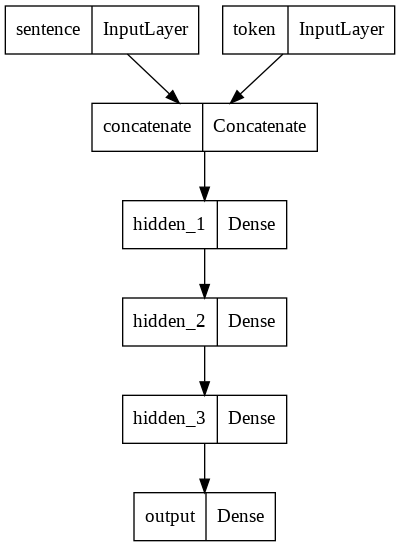

In [ ]:
plot_model(model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.Accuracy()])

In [ ]:
sentence_vector[0]

tensor([-0.0790, -0.0913, -0.0893, -0.1063, -0.1148, -0.1195, -0.1141, -0.1170,
        -0.0990, -0.0945, -0.1133, -0.0990, -0.1038, -0.1010, -0.1095, -0.1054,
        -0.0574, -0.0967, -0.1103, -0.1060, -0.1065, -0.1032, -0.0900, -0.1038,
        -0.0523, -0.0614, -0.1292, -0.1193, -0.1308, -0.1097, -0.1221, -0.1319,
        -0.1347, -0.1355, -0.1429, -0.1055, -0.1419, -0.1398, -0.1408, -0.1459,
        -0.1383, -0.1451, -0.1454, -0.1465, -0.1473, -0.1463, -0.1476, -0.1425,
        -0.1472, -0.1399, -0.1397, -0.1204, -0.1410, -0.1376, -0.1027, -0.1280,
        -0.1294, -0.1306, -0.1322, -0.1420, -0.1445, -0.1469, -0.1390, -0.1367,
        -0.1404, -0.1128, -0.1396, -0.1438, -0.1444, -0.1521, -0.1459, -0.1437,
        -0.1377, -0.1470, -0.1490, -0.1371, -0.1410, -0.1407, -0.1254, -0.0986,
        -0.1205, -0.1032, -0.1143, -0.1321, -0.1009, -0.1321, -0.1307, -0.1338,
        -0.1385, -0.1460, -0.1478, -0.1399, -0.1370, -0.1280, -0.1421, -0.1327,
        -0.1407, -0.1449, -0.1459, -0.15

In [ ]:
torch.hstack((sentence_vector[0], token_vector[0])).cpu().detach().numpy()

array([-0.07904724, -0.09131112, -0.08934796, -0.10626918, -0.11478686,
       -0.11951705, -0.1141452 , -0.11697226, -0.09895003, -0.09454932,
       -0.11327354, -0.09897339, -0.10382912, -0.10099115, -0.10952029,
       -0.10536782, -0.05743402, -0.09673097, -0.11029582, -0.1060425 ,
       -0.10649345, -0.10323736, -0.08996964, -0.10383734, -0.05229133,
       -0.06138842, -0.1291774 , -0.11930407, -0.13078792, -0.10966134,
       -0.12207201, -0.13194503, -0.13467674, -0.13554908, -0.14293574,
       -0.10549742, -0.1418608 , -0.13983713, -0.14079463, -0.14585711,
       -0.13832079, -0.14509849, -0.14535925, -0.14646369, -0.14729501,
       -0.14626455, -0.14764878, -0.14250085, -0.14718689, -0.13989322,
       -0.13973676, -0.12041098, -0.14102875, -0.13757376, -0.10269091,
       -0.12795162, -0.12942068, -0.1306361 , -0.1321824 , -0.14196764,
       -0.14454837, -0.14689647, -0.13903321, -0.13668002, -0.14043373,
       -0.11276272, -0.13959756, -0.14376466, -0.14442013, -0.15

In [ ]:
nn = []
for s, t in zip(sentence_vector, token_vector):
  nn.append(torch.hstack((s, t)).cpu().detach().numpy())

nn = np.asarray(nn)

In [ ]:
nn_test = []
for s, t in zip(test_sent_vec, test_token_vec):
  nn_test.append(torch.hstack((s, t)).cpu().detach().numpy())

nn_test = np.asarray(nn_test)

In [ ]:
nn[0]

array([-0.07904724, -0.09131112, -0.08934796, -0.10626918, -0.11478686,
       -0.11951705, -0.1141452 , -0.11697226, -0.09895003, -0.09454932,
       -0.11327354, -0.09897339, -0.10382912, -0.10099115, -0.10952029,
       -0.10536782, -0.05743402, -0.09673097, -0.11029582, -0.1060425 ,
       -0.10649345, -0.10323736, -0.08996964, -0.10383734, -0.05229133,
       -0.06138842, -0.1291774 , -0.11930407, -0.13078792, -0.10966134,
       -0.12207201, -0.13194503, -0.13467674, -0.13554908, -0.14293574,
       -0.10549742, -0.1418608 , -0.13983713, -0.14079463, -0.14585711,
       -0.13832079, -0.14509849, -0.14535925, -0.14646369, -0.14729501,
       -0.14626455, -0.14764878, -0.14250085, -0.14718689, -0.13989322,
       -0.13973676, -0.12041098, -0.14102875, -0.13757376, -0.10269091,
       -0.12795162, -0.12942068, -0.1306361 , -0.1321824 , -0.14196764,
       -0.14454837, -0.14689647, -0.13903321, -0.13668002, -0.14043373,
       -0.11276272, -0.13959756, -0.14376466, -0.14442013, -0.15

In [ ]:
tf_sentence_vector = []
for s in sentence_vector:
  tf_sentence_vector.append(s.detach().numpy())

In [ ]:
tf_token_vector = []
for t in token_vector:
  tf_token_vector.append(t.detach().numpy())

In [ ]:
tf_label_vector = []
for t in label_vector:
  tf_label_vector.append(int(np.floor(t*5)))

In [ ]:
test_y_label = (test.complexity * 5).astype('int')
max(test_y_label)

3

In [ ]:
tf_token_vector = []
for t in token_vector:
  t = t.detach().numpy()
  tf_token_vector.append(t)
  #print(tf_token_vector)

In [ ]:
tf_label_vector

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,


In [ ]:
arr = np.array(tf_token_vector)

In [ ]:
arr_transpose = arr.reshape(len(arr), 1)
arr_transpose

array([[-0.11697226],
       [-0.10704526],
       [-0.10149771],
       ...,
       [-0.10296905],
       [-0.10770255],
       [-0.10119956]], dtype=float32)

In [ ]:
arr2 = np.array(tf_sentence_vector)
arr2

array([[-0.07904724, -0.09131112, -0.08934796, ..., -0.14115642,
        -0.13774213, -0.1322624 ],
       [-0.08109822, -0.09356999, -0.09826689, ..., -0.13131683,
        -0.09085228, -0.1283866 ],
       [-0.08266314, -0.10043234, -0.10246885, ..., -0.14028269,
        -0.11429688, -0.10454222],
       ...,
       [-0.08043163, -0.09058952, -0.10253265, ..., -0.09517679,
        -0.12408087, -0.12899627],
       [-0.08245849, -0.10309475, -0.1103489 , ..., -0.13146994,
        -0.11308021, -0.12054795],
       [-0.07738262, -0.08838028, -0.09999075, ..., -0.1488582 ,
        -0.13686943, -0.14000838]], dtype=float32)

In [ ]:
test_tf_sent = []
for s in test_sent_vec:
  test_tf_sent.append(s.detach().numpy())

test_tf_tok = []
for t in test_token_vec:
  test_tf_tok.append(t.detach().numpy())

test_tf_lab = []
for l in test_label_vec:
  test_tf_lab.append(int(np.floor(l*5)))

In [ ]:
arr_test = np.array(test_token_vec)
arr_trans_test = arr_test.reshape(len(arr_test), 1)
arr2_test = np.array(test_tf_sent)
test_x = np.concatenate((arr2_test, arr_trans_test), 1)

In [ ]:
test_y = np.array(test_tf_lab)

In [ ]:
test_y

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,

In [ ]:
train_x = np.concatenate((arr2, arr_transpose), 1)

In [ ]:
label_vector

[0.0,
 0.0,
 0.0499999999999999,
 0.15,
 0.2638888888888888,
 0.2647058823529411,
 0.0,
 0.0555555555555555,
 0.1607142857142857,
 0.1607142857142857,
 0.171875,
 0.0,
 0.1805555555555555,
 0.25,
 0.0,
 0.21875,
 0.28125,
 0.3157894736842105,
 0.0,
 0.0555555555555555,
 0.125,
 0.1333333333333333,
 0.3035714285714286,
 0.125,
 0.0,
 0.1666666666666666,
 0.0,
 0.0,
 0.1607142857142857,
 0.2794117647058823,
 0.0,
 0.0499999999999999,
 0.1607142857142857,
 0.1764705882352941,
 0.2083333333333333,
 0.0,
 0.1333333333333333,
 0.2222222222222222,
 0.025,
 0.0999999999999999,
 0.1666666666666666,
 0.2352941176470588,
 0.265625,
 0.109375,
 0.025,
 0.1176470588235294,
 0.1607142857142857,
 0.234375,
 0.025,
 0.0499999999999999,
 0.0999999999999999,
 0.2105263157894736,
 0.2282608695652174,
 0.025,
 0.2941176470588235,
 0.025,
 0.125,
 0.1323529411764705,
 0.234375,
 0.2894736842105263,
 0.025,
 0.0277777777777777,
 0.0999999999999999,
 0.238095238095238,
 0.2638888888888888,
 0.027777777777777

In [ ]:
train_y = np.floor(np.array(label_vector)*5)

In [ ]:
type(label_vector)

list

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
model2 = SGDClassifier(max_iter=1000, tol=1e-3, early_stopping=True, class_weight="balanced")

In [ ]:
max(np.array(label_vector)*5)

4.305555555555555

In [ ]:
dir(train_y)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [ ]:
model2.fit(X=train_x, y = train_y)

SGDClassifier(class_weight='balanced', early_stopping=True)

In [ ]:
MAX_LEN = 512

In [ ]:
sent_vec = keras.Input(shape=(MAX_LEN,), name="sentence")
token_vec = keras.Input(shape=(1,), name="token")

#create the other hidden layers and the output layer
features = layers.Concatenate()([sent_vec, token_vec])

hidden_1 = layers.Dense(512, activation='relu', name="hidden_1")(features)
hidden_2 = layers.Dense(128, activation='relu', name="hidden_2")(hidden_1)
hidden_3 = layers.Dense(64, activation='relu', name="hidden_3")(hidden_2)
outputs = layers.Dense(5, activation='softmax', name="output")(hidden_3)
model_cat = keras.Model(inputs=[sent_vec, token_vec], outputs=outputs)

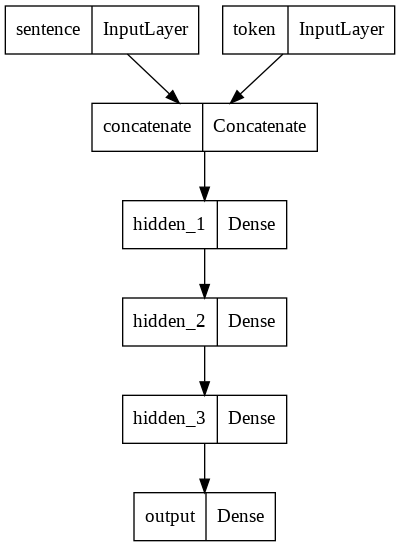

In [ ]:
plot_model(model_cat)

In [ ]:
model_cat.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_dim=513, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [ ]:
nn.shape

(7615, 513)

In [ ]:
model.fit(x=nn,
          y=np.asarray(token_vector),
          epochs=30, batch_size=64)

Epoch 1/30
119/119 [==============================] - 2s 5ms/step - loss: 1.3546e-04 - mae: 0.0082
Epoch 2/30
119/119 [==============================] - 1s 6ms/step - loss: 1.3440e-04 - mae: 0.0082
Epoch 3/30
119/119 [==============================] - 1s 5ms/step - loss: 1.3347e-04 - mae: 0.0082
Epoch 4/30
119/119 [==============================] - 1s 6ms/step - loss: 1.3387e-04 - mae: 0.0082
Epoch 5/30
119/119 [==============================] - 1s 7ms/step - loss: 1.3500e-04 - mae: 0.0082
Epoch 6/30
119/119 [==============================] - 1s 7ms/step - loss: 1.3506e-04 - mae: 0.0082
Epoch 7/30
119/119 [==============================] - 1s 6ms/step - loss: 1.3460e-04 - mae: 0.0082
Epoch 8/30
119/119 [==============================] - 1s 6ms/step - loss: 1.3354e-04 - mae: 0.0082
Epoch 9/30
119/119 [==============================] - 1s 7ms/step - loss: 1.3479e-04 - mae: 0.0082
Epoch 10/30
119/119 [==============================] - 1s 6ms/step - loss: 1.3358e-04 - mae: 0.0082
Epoch 11/

In [ ]:
train_y[100:110]

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])

In [ ]:
np.floor(data.complexity * 5)[100:110]

100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
105    0.0
106    1.0
107    1.0
108    0.0
109    0.0
Name: complexity, dtype: float64

In [ ]:
numpyarray = []
for s, t in zip(tf_sentence_vector, tf_token_vector):
  a = s.tolist()
  a.append(t.tolist())
  numpyarray.append(a)

In [ ]:
n = np.asarray(numpyarray)

In [ ]:
n.ndim

2

In [ ]:
model_cat.fit(x=[np.array(tf_sentence_vector), np.array(tf_token_vector)],
          y=train_y,
          epochs=30, batch_size=64)

Epoch 1/30
119/119 [==============================] - 4s 3ms/step - loss: 1.1666 - accuracy: 0.5790
Epoch 2/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0763 - accuracy: 0.5837
Epoch 3/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0722 - accuracy: 0.5837
Epoch 4/30
119/119 [==============================] - 0s 4ms/step - loss: 1.0724 - accuracy: 0.5837
Epoch 5/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0713 - accuracy: 0.5837
Epoch 6/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0681 - accuracy: 0.5837
Epoch 7/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0683 - accuracy: 0.5837
Epoch 8/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0683 - accuracy: 0.5837
Epoch 9/30
119/119 [==============================] - 0s 3ms/step - loss: 1.0685 - accuracy: 0.5837
Epoch 10/30
119/119 [==============================] - 0s 4ms/step - loss: 1.0680 - accuracy: 0.5837

In [ ]:
len(test_tf_sent)

910

In [ ]:
model_cat.evaluate(x=[np.array(test_tf_sent), np.array(test_tf_tok)],
          y=np.array(test_tf_lab))

29/29 [==============================] - 0s 3ms/step - loss: 1.0069 - accuracy: 0.6132


[1.006864070892334, 0.6131868362426758]

In [ ]:
model.evaluate(x=nn,
          y=np.asarray(label_vector))

238/238 [==============================] - 1s 3ms/step - loss: 0.1762 - mae: 0.3982


[0.17621001601219177, 0.39817726612091064]

In [ ]:
pred = model_cat.predict([np.array(test_tf_sent), np.array(test_tf_tok)])

29/29 [==============================] - 0s 2ms/step


In [ ]:
pred = model.predict(nn_test)

29/29 [==============================] - 0s 2ms/step


In [ ]:
pred

array([[-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0.09613226],
       [-0

In [ ]:
test_tf_sent

[array([-0.08005066, -0.08687491, -0.09142884, -0.09603274, -0.11440426,
        -0.10890248, -0.11933812, -0.0941034 , -0.11620877, -0.09934082,
        -0.09842087, -0.11652862, -0.11100495, -0.09351319, -0.05938341,
        -0.10188654, -0.11719275, -0.09923816, -0.10587548, -0.10713582,
        -0.09556476, -0.1039282 , -0.10390136, -0.088736  , -0.10662378,
        -0.10601562, -0.09662836, -0.09686091, -0.05359088, -0.05626237,
        -0.11669119, -0.11162878, -0.12212837, -0.12063199, -0.1072456 ,
        -0.12464648, -0.12485693, -0.1283467 , -0.1271819 , -0.10839044,
        -0.13156195, -0.12569843, -0.10831145, -0.13835016, -0.13477951,
        -0.15034574, -0.15087809, -0.15123181, -0.1389722 , -0.14700003,
        -0.1382259 , -0.1396406 , -0.13287354, -0.10869604, -0.1330952 ,
        -0.10350358, -0.12012655, -0.12007832, -0.13104393, -0.14499074,
        -0.14788589, -0.13822243, -0.13417381, -0.14163193, -0.14206511,
        -0.14322066, -0.13631575, -0.13945135, -0.1

In [ ]:
test_tf_tok

[array(-0.0941034, dtype=float32),
 array(-0.1036123, dtype=float32),
 array(-0.09361094, dtype=float32),
 array(-0.10057879, dtype=float32),
 array(-0.09453726, dtype=float32),
 array(-0.09738442, dtype=float32),
 array(-0.09241032, dtype=float32),
 array(-0.10307459, dtype=float32),
 array(-0.1252972, dtype=float32),
 array(-0.09888501, dtype=float32),
 array(-0.08880702, dtype=float32),
 array(-0.11354183, dtype=float32),
 array(-0.11048302, dtype=float32),
 array(-0.10048182, dtype=float32),
 array(-0.10915337, dtype=float32),
 array(-0.10855561, dtype=float32),
 array(-0.11020863, dtype=float32),
 array(-0.1053721, dtype=float32),
 array(-0.11208702, dtype=float32),
 array(-0.10304735, dtype=float32),
 array(-0.10459752, dtype=float32),
 array(-0.11103678, dtype=float32),
 array(-0.1014826, dtype=float32),
 array(-0.10236683, dtype=float32),
 array(-0.10484437, dtype=float32),
 array(-0.05929537, dtype=float32),
 array(-0.10646562, dtype=float32),
 array(-0.10479806, dtype=float32

In [ ]:
pred_label = []
for p in pred:
  pred_label.append(p.argmax())

In [ ]:
print(classification_report(test_tf_lab, pred_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       187
           1       0.61      1.00      0.76       558
           2       0.00      0.00      0.00       144
           3       0.00      0.00      0.00        21

    accuracy                           0.61       910
   macro avg       0.15      0.25      0.19       910
weighted avg       0.38      0.61      0.47       910



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
r2_score(test_tf_lab, pred_label)

-2.647961466761828e-06

In [ ]:
pred_label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
pearsonr(test_tf_lab, pred_label)

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan)

In [ ]:
prediction = model2.predict(X=test_x)

# Bert

In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
data.head()

id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  
0  Behold, there came up out of the river seven c...     river    0.000000  
1  I am a fellow bondservant with you and with yo...  brothers    0.000000  
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000  
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000  
4                He has put my brothers far from me.  brothers    0.263889

In [ ]:
training_sentences = data.sentence.tolist()
testing_sentences = test.sentence.tolist()

In [ ]:
training_labels = data.complexity.tolist()
testing_labels = test.complexity.tolist()

In [ ]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True,
                            return_tensors="tf")
test_encodings = tokenizer(testing_sentences,
                          truncation=True,
                          padding=True,
                          return_tensors="tf")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    testing_labels
))

In [ ]:
testing_labels

[0.0,
 0.1973684210526315,
 0.2,
 0.2678571428571429,
 0.0,
 0.25,
 0.0277777777777777,
 0.2,
 0.2222222222222222,
 0.3194444444444444,
 0.390625,
 0.0499999999999999,
 0.1666666666666666,
 0.2105263157894736,
 0.2361111111111111,
 0.3055555555555556,
 0.0499999999999999,
 0.2058823529411764,
 0.2058823529411764,
 0.1964285714285714,
 0.3068181818181817,
 0.0535714285714285,
 0.1875,
 0.1875,
 0.1875,
 0.2125,
 0.0666666666666666,
 0.25,
 0.4642857142857143,
 0.075,
 0.125,
 0.1785714285714285,
 0.25,
 0.0833333333333333,
 0.175,
 0.2321428571428571,
 0.0892857142857143,
 0.1333333333333333,
 0.0999999999999999,
 0.0999999999999999,
 0.2205882352941176,
 0.1428571428571428,
 0.2222222222222222,
 0.1071428571428571,
 0.15625,
 0.1833333333333333,
 0.1944444444444444,
 0.2321428571428571,
 0.15625,
 0.1176470588235294,
 0.125,
 0.1527777777777778,
 0.3392857142857143,
 0.3522727272727273,
 0.125,
 0.1875,
 0.2166666666666666,
 0.2166666666666666,
 0.25,
 0.125,
 0.125,
 0.180555555555555

In [ ]:
model_TF = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_59', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(304,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(304,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_TF.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model_TF.fit(train_dataset.shuffle(100).batch(16),
          epochs=5,
          batch_size=16)

Epoch 1/5
479/479 [==============================] - 250s 503ms/step - loss: 0.0060 - accuracy: 9.1360e-04
Epoch 2/5
479/479 [==============================] - 241s 503ms/step - loss: 0.0080 - accuracy: 7.8309e-04
Epoch 3/5
479/479 [==============================] - 241s 502ms/step - loss: 0.0101 - accuracy: 0.0012
Epoch 4/5
479/479 [==============================] - 240s 502ms/step - loss: 0.0099 - accuracy: 0.0021
Epoch 5/5
479/479 [==============================] - 240s 501ms/step - loss: 0.0107 - accuracy: 0.0014


In [ ]:
model_TF.save_pretrained("/tmp/lcp_custom_model")

In [ ]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/tmp/lcp_custom_model")

Some layers from the model checkpoint at /tmp/lcp_custom_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /tmp/lcp_custom_model and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
predict_input = tokenizer.encode(testing_sentences,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]
print(tf_output)

In [ ]:
tf_output = loaded_model.predict(testing_sentences)[0]

##Linear Regression

In [ ]:
max(tf_label_vector_cat)

4

In [ ]:
type(tf_label_vector)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [ ]:
linear_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe6abaa1e90>>

In [ ]:
np.concatenate(tf_sentence_vector, tf_token_vector)

In [ ]:
model = keras.Model(inputs=[sent_vec, token_vec],
                    outputs=[tf.convert_to_tensor(train_label.complexity)])

In [ ]:
train_label.complexity[0]

0.0

In [ ]:
data.complexity[30:60]

30    0.000000
31    0.050000
32    0.160714
33    0.176471
34    0.208333
35    0.000000
36    0.133333
37    0.222222
38    0.025000
39    0.100000
40    0.166667
41    0.235294
42    0.265625
43    0.109375
44    0.025000
45    0.117647
46    0.160714
47    0.234375
48    0.025000
49    0.050000
50    0.100000
51    0.210526
52    0.228261
53    0.025000
54    0.294118
55    0.025000
56    0.125000
57    0.132353
58    0.234375
59    0.289474
Name: complexity, dtype: float64

In [ ]:
data.token[30:60]

30      name
31      name
32      name
33      name
34      name
35    Father
36    Father
37    Father
38    waters
39    waters
40    waters
41    waters
42    waters
43      sign
44      wood
45      wood
46      wood
47      wood
48      gold
49      gold
50      gold
51      gold
52      gold
53      weep
54      weep
55    silver
56    silver
57    silver
58    silver
59    silver
Name: token, dtype: object

#Update 1

In [ ]:
result = tokenizer.tokenize(data.sentence[5000])
result

['[CLS]',
 'it',
 'is',
 'therefore',
 'abundant',
 '##ly',
 'clear',
 'that',
 'investing',
 'in',
 'health',
 'systems',
 'is',
 'essential',
 'in',
 'the',
 'fight',
 'against',
 'poverty',
 '.',
 '[SEP]']

In [ ]:
index_value = token.convert_tokens_to_ids(result)
index_value

[101,
 2009,
 2003,
 3568,
 12990,
 2135,
 3154,
 2008,
 19920,
 1999,
 2740,
 3001,
 2003,
 6827,
 1999,
 1996,
 2954,
 2114,
 5635,
 1012,
 102]

In [ ]:
data_bible = data[data['corpus']=="bible"]
data_europarl = data[data['corpus']=="europarl"]
data_biomed = data[data['corpus']=="biomed"]
y_train = pd.DataFrame(data['complexity'])
y_bible = data_bible['complexity']
y_europarl = data_europarl['complexity']
y_biomed = data_biomed['complexity']
token_train = pd.DataFrame(data['token'])

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/lcp_single_test.tsv.txt",
                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')

In [ ]:
df_test = test.copy()

In [ ]:
test_bible = df_test[df_test['corpus']=="bible"]
test_europarl = df_test[df_test['corpus']=="europarl"]
test_biomed = df_test[df_test['corpus']=="biomed"]

In [ ]:
df_test.head()

id corpus  \
0  3K8CQCU3KE19US5SN890DFPK3SANWR  bible   
1  3Q2T3FD0ON86LCI41NJYV3PN0BW3MV  bible   
2  3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B  bible   
3  3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD  bible   
4  3QREJ3J433XSBS8QMHAICCR0BQ1LKR  bible   

                                            sentence     token  complexity  \
0  But he, beckoning to them with his hand to be ...      hand    0.000000   
1  If I forget you, Jerusalem, let my right hand ...      hand    0.197368   
2  the ten sons of Haman the son of Hammedatha, t...      hand    0.200000   
3  Let your hand be lifted up above your adversar...      hand    0.267857   
4  Abimelech chased him, and he fled before him, ...  entrance    0.000000   

                                           processed  
0  [hand, but he beckoning to them with his hand ...  
1  [hand, if i forget you jerusalem let my right ...  
2  [hand, the ten sons of haman the son of hammed...  
3  [hand, let your hand be lifted up above your a...  
4  [entrance, abimelech chased him and he fled be...

In [ ]:
data.head()

id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  \
0  Behold, there came up out of the river seven c...     river    0.000000   
1  I am a fellow bondservant with you and with yo...  brothers    0.000000   
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000   
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000   
4                He has put my brothers far from me.  brothers    0.263889   

                                           processed  
0  [river, behold there came up out of the river ...  
1  [brothers, i am a fellow bondservant with you ...  
2  [brothers, the man the lord of the land said t...  
3  [brothers, shimei had sixteen sons and six dau...  
4     [brothers, he has put my brothers far from me]

In [ ]:
type(token_train)

pandas.core.frame.DataFrame

In [ ]:
y_train

complexity
0       0.000000
1       0.000000
2       0.050000
3       0.150000
4       0.055556
...          ...
7227    0.656250
7228    0.671875
7229    0.675000
7230    0.678571
7231    0.680556

[7232 rows x 1 columns]

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import random
import csv
import json
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import scipy

In [ ]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)

In [ ]:
original_to_standard = {}
original_to_standard[0]=0
original_to_standard[0.25]=1
original_to_standard[0.5]=2
original_to_standard[0.75]=3
original_to_standard[1]=4
standard_to_original = {}
standard_to_original[0]=0
standard_to_original[1]=0.25
standard_to_original[2]=0.5
standard_to_original[3]=0.75
standard_to_original[4]=1


In [ ]:
def get_train_data_electra(tokens, embeddings_dict, complexity):
    x_train = []
    for i in range(len(tokens)):
        temp = np.array(embeddings_dict[tokens[i]])
        x_train.append(temp)

    x_train = np.array(x_train, dtype=np.float32)
    y_train = complexity

    return x_train, y_train


In [ ]:
def mae(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred))


In [ ]:
def training(x_train, y_train):
    model = LinearRegression().fit(x_train, y_train)
    return model



In [ ]:
def predict(model, x):
    predicted = model.predict(x)
    return predicted

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import random
import csv
import json
from tqdm import tqdm

In [ ]:
from transformers import ElectraTokenizer, ElectraModel, ElectraConfig
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
# model = ElectraModel.from_pretrained('google/electra-small-discriminator', return_dict=True)

configuration = ElectraConfig()

# #Initializing a model from the electra-base-uncased style configuration
# model = ElectraModel(configuration)

# Load pre-trained model (weights)
model = ElectraModel.from_pretrained('google/electra-small-discriminator', output_hidden_states = True)

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), e

In [ ]:
def computeLPSArray(pat, M, lps):
    len = 0 # length of the previous longest prefix suffix

    lps[0] # lps[0] is always 0
    i = 1

    # the loop calculates lps[i] for i = 1 to M-1
    while i < M:
        if pat[i]== pat[len]:
            len += 1
            lps[i] = len
            i += 1
        else:
            # This is tricky. Consider the example.
            # AAACAAAA and i = 7. The idea is similar
            # to search step.
            if len != 0:
                len = lps[len-1]

                # Also, note that we do not increment i here
            else:
                lps[i] = 0
                i += 1

def KMPSearch(pat, txt):
    M = len(pat)
    N = len(txt)

    # create lps[] that will hold the longest prefix suffix
    # values for pattern
    lps = [0]*M
    j = 0 # index for pat[]

    # Preprocess the pattern (calculate lps[] array)
    computeLPSArray(pat, M, lps)

    i = 0 # index for txt[]
    while i < N:
        if pat[j] == txt[i]:
            i += 1
            j += 1

        if j == M:
            return np.arange(i-j, i-j+M, dtype=int).tolist()
            j = lps[j-1]

        # mismatch after j matches
        elif i < N and pat[j] != txt[i]:
            # Do not match lps[0..lps[j-1]] characters,
            # they will match anyway
            if j != 0:
                j = lps[j-1]
            else:
                i += 1

    return list()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/lcp_single_train.tsv.txt",
                              delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
# df = df.append(pd.read_csv("../Group 1 Dataset/Dataset 1/lcp_single_trial.tsv",
#                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8'))
# df = df.append(pd.read_csv("../Group 1 Dataset/Dataset 2/lcp_multi_train.tsv",
#                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8'))
# df = df.append(pd.read_csv("../Group 1 Dataset/Dataset 2/lcp_multi_trial.tsv",
#                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8'))
df = df.append(pd.read_csv("/content/drive/MyDrive/lcp_single_test.tsv.txt",
                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8'))
# df = df.append(pd.read_csv("../Group 1 Dataset/Test/lcp_multi_test.tsv",
#                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8'))
df = df.reset_index(drop=True)

Embed = {}

for i in tqdm(range(len(df))):
# for i in range(1):
    df['sentence'][i] = "[CLS] " + df['sentence'][i] + " [SEP]"
    tokenized_text = tokenizer.tokenize(df['sentence'][i])
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    word_token=tokenizer.tokenize(str(df['token'][i]))
    segments_ids = [1] * len(tokenized_text)
    token_indices = KMPSearch(word_token, tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():

        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[0]

    token_embeddings = torch.squeeze(hidden_states, dim=0)

    embedding = np.zeros(token_embeddings[0].numpy().shape, dtype = np.float32)
    if len(token_indices) > 0:
        for j in token_indices:
            embedding += token_embeddings[j].numpy()
        embedding = embedding/len(token_indices)
    Embed[df['id'][i]] = embedding.tolist()

  0%|          | 0/8579 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 3/8579 [00:00<19:57,  7.16it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 26/8579 [00:04<09:12, 15.48it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
import os
os.chdir("/content/drive/MyDrive/")

In [ ]:
pwd

'/content/drive/MyDrive'

In [ ]:
with open("Electra_embeddings.json", "w") as outfile:
    json.dump(Embed, outfile, indent = 4)

In [ ]:
t = KMPSearch(word_token, tokenized_text)

In [ ]:
word_token

['dell']

In [ ]:
token_indices

[11]

In [ ]:
indexed_tokens

[101,
 5921,
 1996,
 8924,
 2008,
 11925,
 2033,
 2001,
 1996,
 26445,
 6895,
 12418,
 1005,
 4748,
 18153,
 3258,
 2063,
 1012,
 102]

In [ ]:
print("outputs", outputs['last_hidden_state'])


outputs tensor([[[ 0.1273,  0.9941, -0.4852,  ...,  1.7917, -1.2305,  0.2259],
         [ 0.0126,  0.2651, -0.1953,  ...,  0.6903, -0.3741,  0.8855],
         [-0.3581,  0.9472, -0.2789,  ..., -0.1410, -0.0780,  0.6331],
         ...,
         [-0.1678, -0.2178,  0.3270,  ...,  0.8134, -0.7169,  0.0528],
         [ 0.1332, -0.6635, -0.4635,  ...,  0.5847, -0.5122,  0.2076],
         [ 0.1256,  0.9969, -0.4826,  ...,  1.7900, -1.2287,  0.2266]]])


In [ ]:
print("hidden_states", hidden_states.shape)

hidden_states torch.Size([1, 19, 256])


In [ ]:
print(tokens_tensor)
print(segments_tensors)

tensor([[  101,  5921,  1996,  8924,  2008, 11925,  2033,  2001,  1996, 26445,
          6895, 12418,  1005,  4748, 18153,  3258,  2063,  1012,   102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
model

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), e

In [ ]:

# returns JSON object as a dictionary
embeddings_dict1 = Embed

In [ ]:
def ensemble(predictions):
#    predicted = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4])/5
    predicted = predictions[0]
    return predicted

In [ ]:

def training_util(df, embeddings_dict):
    tokens = df['id'].values
    complexity = df['complexity'].values

    x_train, y_train = get_train_data_electra(tokens, embeddings_dict, complexity)
    model = training(x_train, y_train)

    return model

In [ ]:
def testing_util(df, model, embeddings_dict):
    tokens = df['id'].values
    complexity = df['complexity'].values

    x_test, y_test = get_train_data_electra(tokens, embeddings_dict, complexity)
    return predict(model, x_test)

In [ ]:
def generate_annotations(df,n=20):
    scores = df['complexity']
    annotations = []
    for i in range(len(scores)):
        if scores[i]>=0 and scores[i]<0.25:
            low = 0
            high = 0.25
        elif scores[i]>=0.25 and scores[i]<0.5:
            low = 0.25
            high = 0.5
        elif scores[i]>=0.5 and scores[i]<0.75:
            low = 0.5
            high = 0.75
        elif scores[i]>=0.75 and scores[i]<1:
            low = 0.75
            high = 1
        alpha = (high - scores[i])/(high-low)
        num_low = int(np.floor(alpha*n))
        num_high = n - num_low

        temp = int(original_to_standard[high])*np.ones(n,dtype=int)
        for i in range(num_low):
            temp[i]=int(original_to_standard[low])
        annotations.append(temp.tolist())
    #     print(num_low, num_high)
    annotations = np.array(annotations)

    return annotations

def zscore(x, m, s):
    for i in range(len(x[0,:])):
        x[:,i] = (x[:,i] - m[i])/s[i]
    return x

def getx_train(tokens, embeddings_dict):
    x_train = []
    print("token", tokens)
    for i in range(len(tokens)):
        temp = np.array(embeddings_dict[tokens[i]])
        x_train.append(temp)

    x_train = np.array(x_train, dtype = np.float32)
    return x_train

In [ ]:
def classification(x, y):
  print("classification x", x)
  print("classification y", y)
#     clf = SVC(kernel = 'linear', verbose=1, C = 1).fit(x, y)
  clf = SVC(kernel = 'rbf', verbose=1,C = 1).fit(x, y)
#     clf = SVC(kernel = 'sigmoid', verbose=1, C = 1).fit(x, y)
#     clf = RandomForestClassifier(max_depth = 18, verbose=1).fit(x, y)
#     clf = KNeighborsClassifier(n_neighbors = 5, verbose=1).fit(x, y)
#     clf = LogisticRegression(random_state=0, verbose=1).fit(x, y)
#     gnb = GaussianNB(verbose=1).fit(x, y)

  return clf

In [ ]:
def predict(clf, x):
    return clf.predict(x)

def mae(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred))

def train_test2(df_train,df_test, embeddings_dict1, n=20):
    annotations = generate_annotations(df_train,n)
    print("annotations", annotations)
    x_train = getx_train(df_train['id'], embeddings_dict1)
    x_test = getx_train(df_test['id'], embeddings_dict1)
    predictions = []
    for i in range(n):
        y_train = annotations[:,i]
        model = classification(x_train, y_train)
        predictions.append(predict(model,x_test))
    print("predictions", predictions)
    y_test = df_test['complexity']

    pred = np.array(predictions, dtype = float)
    for i in range(len(pred)):
        for j in range(len(pred[i])):
            pred[i,j]=standard_to_original[int(pred[i,j])]

    y_pred = np.zeros(y_test.shape,dtype=float)
    for j in range(len(y_test)):
        y_pred[j] = pred[:,j].mean()

    return y_pred

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/lcp_single_train.tsv.txt",
                               delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')

In [ ]:
generate_annotations(df_train)[5:10]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [ ]:
model1 = training_util(df_train, embeddings_dict1)

In [ ]:
model1

LinearRegression()

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
training_data = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
type(training_data[0])

tuple

In [ ]:

def train_test(df_train, embeddings_dict1):
    # Training BERT Model
    model1 = training_util(df_train, embeddings_dict1)
    # Training Electra Model
    # model2 = training_util(df_train, embeddings_dict2)
    # # Training Glove Model
    # model3 = training_util(df_train, embeddings_dict3)
    # # Training HC Model
    # model4 = training_util(df_train, embeddings_dict4)

    # Testing on All
    df = df_test
    tokens = df['id'].values
    complexity = df['complexity']
    x_test, y_test = get_train_data_electra(tokens, embeddings_dict1, complexity)
    print("tokens", tokens)

    predictions = []
# Regression
    # BERT
    predictions.append(testing_util(df, model1, embeddings_dict1))

    # Electra
    # predictions.append(testing_util(df, model2, embeddings_dict2))

    # Glove
#     predictions.append(testing_util(df, model3, embeddings_dict3))


# Classification

#     predictions.append(train_test2(df_train,df_test, embeddings_dict2, 30))

    # predictions.append(train_test2(df_train,df_test, embeddings_dict3, 50))

    # HC
#     predictions.append(testing_util(df, model4, embeddings_dict4))

#     predictions.append(train_test2(df_train,df_test, embeddings_dict4, 30))

    return predictions, y_test

In [ ]:
predictions, y_test = train_test(df_train, embeddings_dict1)

tokens ['3K8CQCU3KE19US5SN890DFPK3SANWR' '3Q2T3FD0ON86LCI41NJYV3PN0BW3MV'
 '3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B' '3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD'
 '3QREJ3J433XSBS8QMHAICCR0BQ1LKR' '30F94FBDNRKF12C1PDZGZ0IRI9XTB1'
 '3JHB4BPSFK9JLT5CAPRP3PCEA2CQ9R' '3Y40HMYLL1I1EIURUEH8TTVLKQ9XUM'
 '30Y6N4AHYPWV0KXTZKLRUB59XBPRDA' '38O9DZ0A62NFBR1TA7YCNXN94XN26F'
 '3EHIMLB7F7Z6UVNZM7YHUFP2Z9HH8G' '3SA4EMRVJV2GPNGKAGT7A9LB24SP0N'
 '334ZEL5JX6FY5WOV4IZCVFM4NP9SOM' '39O0SQZVJN7FJBWJ87I5UJVDB0MR7H'
 '34D9ZRXCYRU93SUUUZUUUK2ZYABSAX' '3VADEH0UHCXGQW0WJICRKFRUXUFSPD'
 '3ZICQFRS31I75COG1J4176QBUACZZ4' '37PGLWGSJT6QLR0K1ED5KWZ8UOYKI7'
 '3AC6MFV69KILEROMVXYU7ZM6YKVZHE' '30U1YOGZGAW71ZX6E9LWKLA5JBCSDZ'
 '3D17ECOUOEV9PNWF8100BB1K20131N' '3EKTG13IZU3N1G8T7TNYRPJ40XMMLR'
 '3P4ZBJFX2V3X60SBPKQN5AGB13KWFT' '3ZTE0JGGCESIYFZZ7W9CGAIM1OOCOH'
 '3QI9WAYOGQB8GQIR4MDIEF0D2RFS61' '3MJ9GGZYO36GYTDW0KFO32PV0G7A27'
 '3K2CEDRACB1BKTGYG2PPDGTLUAEMT0' '33NOQL7T9OZSLGNTST4OUMT7VZYZ8O'
 '3RSBJ6YZECQP1RJ9YYZDOG3PYZ8OFS' '3P458N04Q1HSU6LPBU72

In [ ]:
predictions

[array([0.1019263 , 0.15782979, 0.13671042, 0.10283926, 0.18369535,
        0.19006574, 0.27491584, 0.26193354, 0.2514698 , 0.23867057,
        0.2342507 , 0.21365304, 0.22361673, 0.23623987, 0.22178698,
        0.21108551, 0.24489349, 0.25375968, 0.22417325, 0.16017728,
        0.23894301, 0.22664285, 0.24118647, 0.22732344, 0.2281113 ,
        0.20836966, 0.30450195, 0.28960532, 0.34587651, 0.23966612,
        0.25030762, 0.26950118, 0.2120145 , 0.23237947, 0.24881507,
        0.25230592, 0.28160703, 0.2282701 , 0.3020984 , 0.26385325,
        0.15588431, 0.1940197 , 0.2516073 , 0.22622442, 0.15447143,
        0.12420011, 0.16716298, 0.12841082, 0.17360748, 0.23667312,
        0.1147424 , 0.15850131, 0.2160027 , 0.17801762, 0.2153025 ,
        0.18880278, 0.27651617, 0.25743294, 0.26302505, 0.21934718,
        0.1588871 , 0.16904506, 0.20767619, 0.18206379, 0.13435124,
        0.15648983, 0.16702747, 0.1692465 , 0.14355318, 0.20314139,
        0.23636189, 0.12399793, 0.16794086, 0.19

In [ ]:
y_test

0      0.000000
1      0.197368
2      0.200000
3      0.267857
4      0.000000
         ...   
912    0.569444
913    0.535714
914    0.546875
915    0.571429
916    0.583333
Name: complexity, Length: 917, dtype: float64

In [ ]:
len(predictions[0])

917

In [ ]:
y_pred = train_test2(df_train, df_test, embeddings_dict1)

annotations [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
token 0       3ZLW647WALVGE8EBR50EGUBPU4P32A
1       34R0BODSP1ZBN3DVY8J8XSIY551E5C
2       3S1WOPCJFGTJU2SGNAN2Y213N6WJE3
3       3BFNCI9LYKQN09BHXHH9CLSX5KP738
4       3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2
                     ...              
7657    37NXA7GVST66R322LLOPEL2HRRKLVV
7658    31S7M7DAGGQREBYDGQOAD3EWU7KTL5
7659    31D0ZWOD0AZ92JAILXBAKEWG3KOA0S
7660    3THR0FZ95PTB1JT5K92BJT89VYNOLW
7661    363A7XIFV4MPVKBYOUZZ57M6XG1VA5
Name: id, Length: 7662, dtype: object
token 0      3K8CQCU3KE19US5SN890DFPK3SANWR
1      3Q2T3FD0ON86LCI41NJYV3PN0BW3MV
2      3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B
3      3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD
4      3QREJ3J433XSBS8QMHAICCR0BQ1LKR
                    ...              
912    3MIVREZQVHY32PO3EMIETYQUL0GKQF
913    3CVBMEMMXBG2UHIGC26BGFT7OTMH7C
914    3K3G488TR280K6307ZE8R97COALQ50
915    31ODACBENUF1Q81BJVRGKKH42TCSQL
916    3W

In [ ]:
y_pred

array([0.2125, 0.2125, 0.2125, 0.2125, 0.225 , 0.225 , 0.275 , 0.2375,
       0.25  , 0.2375, 0.25  , 0.225 , 0.225 , 0.2375, 0.225 , 0.2125,
       0.225 , 0.2375, 0.2375, 0.2125, 0.225 , 0.2375, 0.225 , 0.2375,
       0.2375, 0.225 , 0.2375, 0.2875, 0.225 , 0.225 , 0.25  , 0.25  ,
       0.225 , 0.225 , 0.225 , 0.225 , 0.275 , 0.2375, 0.25  , 0.2625,
       0.2125, 0.225 , 0.2125, 0.2375, 0.2125, 0.225 , 0.2125, 0.2125,
       0.2   , 0.2125, 0.2125, 0.225 , 0.2375, 0.2125, 0.225 , 0.225 ,
       0.25  , 0.225 , 0.25  , 0.225 , 0.2125, 0.2125, 0.225 , 0.2125,
       0.2125, 0.2125, 0.2125, 0.2125, 0.2125, 0.225 , 0.225 , 0.2125,
       0.2125, 0.225 , 0.2375, 0.2875, 0.25  , 0.2125, 0.2125, 0.225 ,
       0.225 , 0.2375, 0.225 , 0.225 , 0.225 , 0.225 , 0.2375, 0.1875,
       0.2125, 0.2   , 0.225 , 0.225 , 0.225 , 0.225 , 0.2375, 0.275 ,
       0.225 , 0.2125, 0.25  , 0.2375, 0.25  , 0.2   , 0.2125, 0.2   ,
       0.2125, 0.225 , 0.275 , 0.2375, 0.225 , 0.25  , 0.275 , 0.2375,
      

# Section 1

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

In [ ]:
df_train = data.copy()

In [ ]:
tfidf.fit(df_train['sentence'])

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [ ]:
df_train.head()

id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  
0  Behold, there came up out of the river seven c...     river    0.000000  
1  I am a fellow bondservant with you and with yo...  brothers    0.000000  
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000  
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000  
4               "He has put my brothers far from me.  brothers    0.263889

In [ ]:
import sklearn.metrics
from sklearn.metrics import r2_score

In [ ]:
def train_model(df):
  train_x = tfidf.transform(df['sentence'])
  train_y = np.floor((df.complexity * 5))
  model = SGDClassifier(max_iter=1000, tol=1e-3, early_stopping=True, class_weight="balanced")
  #model = SGDClassifier(loss='squared_hinge', max_iter=1000, tol=1e-3, early_stopping=True, class_weight="balanced")
  model.fit(train_x, train_y)
  print(classification_report(train_y, model.predict(train_x)))
  return model

In [ ]:
train_x_tfidf = tfidf.transform(data['sentence'])

In [ ]:
train_x_tfidf

<7662x15148 sparse matrix of type '<class 'numpy.float64'>'
	with 108159 stored elements in Compressed Sparse Row format>

In [ ]:
full_model = train_model(df_train)

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      1600
         1.0       0.93      0.83      0.88      4475
         2.0       0.74      0.87      0.80      1332
         3.0       0.53      0.92      0.67       241
         4.0       0.57      0.86      0.69        14

    accuracy                           0.83      7662
   macro avg       0.71      0.86      0.77      7662
weighted avg       0.85      0.83      0.84      7662



In [ ]:
def evaluate(model, df):
  x = tfidf.transform(df['sentence'])
  y_label = np.floor((df.complexity * 5))

  y_pred = model.predict(x)
  print(classification_report(y_label, y_pred))
  print("Accuracy is: ", sum(y_pred == y_label)/len(y_pred)*100)
  print("Pearson's R is: ", pearsonr(y_label, y_pred))
  print("Rsquared score is: ", r2_score(y_label, y_pred))

In [ ]:
def evaluate(model, df):
  x = tfidf.transform(df['sentence'])
  y_label = np.floor((df.complexity * 5))
  consty = (df.complexity * 5).mean()

  y_pred = model.predict(x)
  print(classification_report(y_label, y_pred))
  print("Accuracy is: ", sum(y_pred == y_label)/len(y_pred)*100)
  print("Const Rsquared score is: ", r2_score([consty for _ in range(len(y_pred))], y_pred))
  print("Rsquared score is: ", r2_score(y_label, y_pred))
  print("Pearson's R is: ", pearsonr(y_label, y_pred)[0])

In [ ]:
evaluate(full_model, df_train)

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      1600
         1.0       0.93      0.83      0.88      4475
         2.0       0.74      0.87      0.80      1332
         3.0       0.53      0.92      0.67       241
         4.0       0.57      0.86      0.69        14

    accuracy                           0.83      7662
   macro avg       0.71      0.86      0.77      7662
weighted avg       0.85      0.83      0.84      7662

Accuracy is:  83.46384755938398
Const Rsquared score is:  -1.6628991116700925e+31
Rsquared score is:  0.39852196160726727
Pearson's R is:  0.7413824929957373


In [ ]:
model_bible = train_model(data_bible)

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       595
         1.0       0.94      0.88      0.91      1443
         2.0       0.83      0.89      0.86       478
         3.0       0.86      0.87      0.86        55
         4.0       0.05      1.00      0.10         3

    accuracy                           0.88      2574
   macro avg       0.71      0.90      0.72      2574
weighted avg       0.90      0.88      0.89      2574



In [ ]:
evaluate(model_bible, data_bible)

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       595
         1.0       0.94      0.88      0.91      1443
         2.0       0.83      0.89      0.86       478
         3.0       0.86      0.87      0.86        55
         4.0       0.05      1.00      0.10         3

    accuracy                           0.88      2574
   macro avg       0.71      0.90      0.72      2574
weighted avg       0.90      0.88      0.89      2574

Accuracy is:  88.03418803418803
Const Rsquared score is:  -1.7506793631598335e+31
Rsquared score is:  0.34545377487435525
Pearson's R is:  0.7381584962751285


In [ ]:
model_biomed = train_model(data_biomed)

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       486
         1.0       0.92      0.77      0.84      1420
         2.0       0.70      0.85      0.77       498
         3.0       0.59      0.91      0.72       161
         4.0       0.67      0.91      0.77        11

    accuracy                           0.80      2576
   macro avg       0.72      0.85      0.77      2576
weighted avg       0.82      0.80      0.80      2576



In [ ]:
evaluate(model_biomed, data_biomed)

              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       486
         1.0       0.92      0.77      0.84      1420
         2.0       0.70      0.85      0.77       498
         3.0       0.59      0.91      0.72       161
         4.0       0.67      0.91      0.77        11

    accuracy                           0.80      2576
   macro avg       0.72      0.85      0.77      2576
weighted avg       0.82      0.80      0.80      2576

Accuracy is:  79.8136645962733
Const Rsquared score is:  0.0
Rsquared score is:  0.35212814462839326
Pearson's R is:  0.7240280661210596


In [ ]:
model_europarl = train_model(data_europarl)

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       519
         1.0       0.95      0.95      0.95      1612
         2.0       0.90      0.92      0.91       356
         3.0       0.88      0.92      0.90        25

    accuracy                           0.93      2512
   macro avg       0.91      0.92      0.91      2512
weighted avg       0.93      0.93      0.93      2512



In [ ]:
evaluate(model_europarl, data_europarl)

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       519
         1.0       0.95      0.95      0.95      1612
         2.0       0.90      0.92      0.91       356
         3.0       0.88      0.92      0.90        25

    accuracy                           0.93      2512
   macro avg       0.91      0.92      0.91      2512
weighted avg       0.93      0.93      0.93      2512

Accuracy is:  93.07324840764332
Const Rsquared score is:  -1.2484990187726245e+31
Rsquared score is:  0.7721454044871371
Pearson's R is:  0.8867093439292687


In [ ]:
evaluate(full_model, df_test)

              precision    recall  f1-score   support

         0.0       0.23      0.23      0.23       188
         1.0       0.62      0.55      0.58       561
         2.0       0.18      0.22      0.20       146
         3.0       0.06      0.14      0.08        22

    accuracy                           0.42       917
   macro avg       0.27      0.28      0.27       917
weighted avg       0.46      0.42      0.44       917

Accuracy is:  42.093784078516904
Const Rsquared score is:  -1.579487037753985e+31
Rsquared score is:  -1.1919657854614054
Pearson's R is:  0.08462205847022569


In [ ]:
np.max(np.floor(df_test.complexity * 5))

3.0

In [ ]:
np.max(np.floor(test_labels * 5))

3.0

In [ ]:
evaluate(model_bible, test_bible)

              precision    recall  f1-score   support

         0.0       0.27      0.27      0.27        66
         1.0       0.59      0.54      0.57       167
         2.0       0.11      0.14      0.12        42
         3.0       0.00      0.00      0.00         8
         4.0       0.00      0.00      0.00         0

    accuracy                           0.41       283
   macro avg       0.19      0.19      0.19       283
weighted avg       0.43      0.41      0.42       283

Accuracy is:  40.63604240282685
Const Rsquared score is:  -1.6245182241922667e+31
Rsquared score is:  -1.1606330265952067
Pearson's R is:  0.03994977049063771


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate(model_biomed, test_biomed)

              precision    recall  f1-score   support

         0.0       0.17      0.17      0.17        58
         1.0       0.54      0.54      0.54       158
         2.0       0.22      0.22      0.22        59
         3.0       0.00      0.00      0.00        14
         4.0       0.00      0.00      0.00         0

    accuracy                           0.37       289
   macro avg       0.19      0.19      0.19       289
weighted avg       0.38      0.37      0.37       289

Accuracy is:  37.37024221453287
Const Rsquared score is:  0.0
Rsquared score is:  -0.9283912442021318
Pearson's R is:  0.06763456353693366


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate(model_europarl, test_europarl)

              precision    recall  f1-score   support

         0.0       0.17      0.16      0.16        64
         1.0       0.68      0.72      0.70       236
         2.0       0.09      0.07      0.08        45
         3.0       0.00      0.00      0.00         0

    accuracy                           0.53       345
   macro avg       0.23      0.24      0.24       345
weighted avg       0.51      0.53      0.52       345

Accuracy is:  53.333333333333336
Const Rsquared score is:  -1.0348239991876358e+31
Rsquared score is:  -0.8804371173880357
Pearson's R is:  -0.004286382400163714


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate(full_model, test_bible)

              precision    recall  f1-score   support

         0.0       0.26      0.30      0.28        66
         1.0       0.60      0.47      0.53       167
         2.0       0.24      0.33      0.28        42
         3.0       0.07      0.12      0.09         8

    accuracy                           0.40       283
   macro avg       0.29      0.31      0.29       283
weighted avg       0.45      0.40      0.42       283

Accuracy is:  40.282685512367486
Const Rsquared score is:  -1.769551221058472e+31
Rsquared score is:  -1.239331580544039
Pearson's R is:  0.07427068548137508


In [ ]:
evaluate(full_model, test_biomed)

              precision    recall  f1-score   support

         0.0       0.18      0.17      0.18        58
         1.0       0.55      0.49      0.52       158
         2.0       0.22      0.22      0.22        59
         3.0       0.06      0.14      0.09        14

    accuracy                           0.36       289
   macro avg       0.25      0.26      0.25       289
weighted avg       0.39      0.36      0.37       289

Accuracy is:  35.6401384083045
Const Rsquared score is:  0.0
Rsquared score is:  -1.2282325657091704
Pearson's R is:  0.061832193612586135


In [ ]:
evaluate(full_model, test_europarl)

              precision    recall  f1-score   support

         0.0       0.23      0.22      0.22        64
         1.0       0.68      0.64      0.66       236
         2.0       0.09      0.11      0.10        45
         3.0       0.00      0.00      0.00         0

    accuracy                           0.49       345
   macro avg       0.25      0.24      0.24       345
weighted avg       0.52      0.49      0.50       345

Accuracy is:  48.98550724637681
Const Rsquared score is:  -1.154333269407885e+31
Rsquared score is:  -1.1583342283320803
Pearson's R is:  0.09209705101420884


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
set(df_test.token)

{'ADAMs',
 'Act',
 'Adjournment',
 'Animal',
 'Anne',
 'Associations',
 'Auditors',
 'Axel',
 'Budgets',
 'Caesar',
 'Caldera',
 'Care',
 'Carmelite',
 'Caspian',
 'Chairmen',
 'Christian',
 'Chromosome',
 'Citizens',
 'Commissioner',
 'Communication',
 'Convention',
 'DEC',
 'Day',
 'Decisions',
 'Desolation',
 'Disease',
 'Documents',
 'Dor',
 'Dorcas',
 'ES',
 'Election',
 'Elizabeth',
 'Envoys',
 'Ephraim',
 'Europe',
 'Expo',
 'Ezra',
 'Fearfulness',
 'Fisheries',
 'Gaius',
 'General',
 'Group',
 'Herman',
 'Indonesia',
 'Interpretation',
 'Kivu',
 'Liberal',
 'Liberals',
 'Lithuania',
 'Medals',
 'Midlands',
 'Millennium',
 'Mouse',
 'Musician',
 'NL',
 'Nations',
 'Netherlands',
 'P',
 'Paul',
 'Pentecost',
 'Portuguese',
 'Prayer',
 'Preparation',
 'Prize',
 'Protection',
 'Qatar',
 'Quinine',
 'RT',
 'Radiological',
 'Rebekah',
 'Referendum',
 'Samaritans',
 'Samuel',
 'Saul',
 'Security',
 'Selah',
 'Sender',
 'Services',
 'Sharon',
 'Sidi',
 'Silvers',
 'Situation',
 'Snail'

In [ ]:
df_train.describe()

complexity
count  7662.000000
mean      0.302288
std       0.132977
min       0.000000
25%       0.211538
50%       0.279412
75%       0.375000
max       0.861111

In [ ]:
df_test.describe()

complexity
count  917.000000
mean     0.296362
std      0.127290
min      0.000000
25%      0.214286
50%      0.276316
75%      0.357143
max      0.777778

In [ ]:
df_train[df_train['corpus'] == 'bible'].count()

id            2574
corpus        2574
sentence      2574
token         2574
complexity    2574
dtype: int64

In [ ]:
df_train[df_train['corpus'] == 'biomed'].count()

id            2576
corpus        2576
sentence      2576
token         2573
complexity    2576
dtype: int64

In [ ]:
df_train[df_train['corpus'] == 'europarl'].count()

id            2512
corpus        2512
sentence      2512
token         2512
complexity    2512
dtype: int64

In [ ]:
len(df_test[df_test['corpus'] == 'bible'])/len(df_test)*100

30.861504907306436

In [ ]:
len(df_test[df_test['corpus'] == 'biomed'])/len(df_test)*100

31.515812431842967

In [ ]:
len(df_test[df_test['corpus'] == 'europarl'])/len(df_test)*100

37.6226826608506

In [ ]:
data[data['complexity']>0.5].token[50:100]

1979            Gad
1981       Golgotha
1984            Hor
1989      Pharisees
1990      Pharisees
1991         Goshen
1992         Goshen
1995           yoke
2000        shekels
2001        shekels
2006         signet
2013         Tarsus
2020          Purim
2021          Purim
2030        travail
2031        travail
2036       Assyrian
2039        eunuchs
2040        eunuchs
2041        eunuchs
2045       Shadrach
2046       Shadrach
2047       Shadrach
2048       Shadrach
2051    soothsayers
2058      Ephesians
2068         coffer
2069     pestilence
2070     pestilence
2071         adders
2072             Og
2073       couriers
2074       dainties
2075       dainties
2076       dainties
2077       dainties
2078       dainties
2079        cistern
2080            Nob
2081            Nob
2082        Hosanna
2083      disrepute
2084        plumage
2085          chaff
2086          Uriel
2087          Uriel
2088            Lud
2089         furrow
2090            Ara
2091         withal


In [ ]:
import tqdm

In [ ]:
l = [0]*16
c = [0]*16
for i in range(len(data.complexity)):
  if len(str(data.token[i]))-1 < 3:
    print(data.token[i])
  l[len(str(data.token[i]))-1] += 1
  c[len(str(data.token[i]))-1] += data.complexity[i]
for j in range(len(c)):
  c[j] /= l[j]
print(l)
print(c)

sin
sin
sin
sin
sin
Son
tax
tax
war
ox
son
son
son
son
son
Eve
net
God
God
God
God
God
men
men
men
men
men
ear
ear
bow
bow
bow
end
sky
sky
sky
sky
sky
day
day
day
day
day
ant
law
law
oil
oil
oil
fat
fat
pit
pit
pit
ram
ram
ram
Cut
Sit
fig
lot
Dan
ewe
ewe
Eli
Eli
Eli
Woe
Nun
rod
rod
Er
Gad
Gad
Gad
Gad
Gad
Hor
Hor
Ahi
Lod
Og
Nob
Nob
Lud
Ara
Ir
Gog
Gog
Ain
Tou
Use
Use
age
age
age
age
age
set
set
set
set
set
fly
fly
aim
gas
use
use
use
ear
ear
ear
sex
sex
sex
sex
sex
eye
eye
eye
eye
eye
rat
rat
dog
fat
fat
fat
New
box
box
nan
nan
nan
lab
B
B
B
tip
mo
mo
mo
mo
mo
X
X
bud
bud
bud
bud
bud
arm
KO
KO
KO
KO
tag
tag
rod
rod
rod
WT
WT
K
K
K
K
K
Kim
XX
XX
XX
XX
XX
CIA
CIA
CIA
CIA
CIA
HY
AER
AER
Le
ER
ER
ER
MA
MA
MA
MA
RC
RC
Cre
Cre
Cre
Cre
Cre
APP
APP
APP
APP
APP
RA
RA
RA
Mb
LOD
LOD
CO
CO
SM
wk
wk
wk
wk
wk
DT
CK
HG
HG
HG
HG
YT
EM
EM
TH
DK
CH
NCO
NCO
CS
SAC
SAM
SAM
cre
cre
cre
AD
AD
AD
AD
AD
Qui
SI
cM
mon
kb
kb
kb
kb
kb
Shh
Ser
Ia
PST
PST
PST
PST
PST
TN
TN
TN
SDS
SDS
SDS
SDS
CF
CF
CF
CF
CF
RM
RM
LN


In [ ]:
length = range(1, 17)
length

range(1, 17)

In [ ]:
plt.bar([i for i in range(1,17)], c)
plt.xlabel("Length of token")
plt.ylabel("Average Complexity")
plt.title("Length of token vs Avg Complexity")
plt.show()

In [ ]:
data['Length'] = l
data.head()

id corpus  \
0  3ZLW647WALVGE8EBR50EGUBPU4P32A  bible   
1  34R0BODSP1ZBN3DVY8J8XSIY551E5C  bible   
2  3S1WOPCJFGTJU2SGNAN2Y213N6WJE3  bible   
3  3BFNCI9LYKQN09BHXHH9CLSX5KP738  bible   
4  3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2  bible   

                                            sentence     token  complexity  \
0  Behold, there came up out of the river seven c...     river    0.000000   
1  I am a fellow bondservant with you and with yo...  brothers    0.000000   
2  The man, the lord of the land, said to us, 'By...  brothers    0.050000   
3  Shimei had sixteen sons and six daughters; but...  brothers    0.150000   
4  He has put my brothers far from me.\tbrothers\...      sons    0.055556   

   len  
0    5  
1    8  
2    8  
3    8  
4    4

In [ ]:
data.groupby(by=['len']).mean()

complexity
len            
1      0.466293
2      0.520547
3      0.360503
4      0.246582
5      0.256762
6      0.274072
7      0.294397
8      0.306637
9      0.315285
10     0.328064
11     0.340266
12     0.335991
13     0.344091
14     0.316299
15     0.327782
16     0.313425

In [ ]:
data.columns

Index(['id', 'corpus', 'sentence', 'token', 'complexity', 'len'], dtype='object')